# The independent test set result 

# Positive taken from DeepNGlyPred Dataset 

# Negative taken from Endoplasmic Reticulum, Golgi Apparatus (GA), Cell Membrane (Cm), Extracellular (Ex) where GA, Cm, and Ex negative sites have RSA > 0.5 

In [1]:
import os
basedir = "/home/d/PycharmProjects/protein_properties"
os.chdir(basedir)

In [2]:
import h5py
import numpy as np
import pandas as pd
import tensorflow as tf
import torch
import torch.nn as nn

from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    matthews_corrcoef,
    f1_score,
    roc_curve, 
    auc
)

from src.models import GlycoModel
from src.utils import mean_confidence_interval

2024-12-15 16:06:54.592292: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734275214.608024  110903 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734275214.612881  110903 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-15 16:06:54.629319: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


**Traverse to working directory where the files are stored**

In [3]:
df_test = pd.read_csv("data/LMNglyPred/df_indepenent_test_again_done_that_has_unique_protein_and_unique_sequence.csv")

In [4]:
df_test

,label,PID,Position,Sequence,Middle_Amino_Acid_ASN(N),1,2,3,4,5,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024
0,1,Q9UKR3,30,GVSQESSKVLNTNGTSGFLPGGYTC,N,-0.206449,-0.117434,0.059543,0.010500,0.101996,...,-0.285171,-0.201855,0.115173,-0.039017,0.251435,-0.490206,-0.079846,0.257386,0.426067,0.251228
1,1,Q7L0Y3,52,MSSKIPAVTYPKNESTPPSEELELD,N,-0.020504,0.099044,0.078951,0.163030,0.064162,...,-0.132599,-0.085727,0.069269,-0.008533,0.079358,-0.214535,-0.116778,0.004320,0.454175,0.186583
2,1,Q9UBV4,288,KIPIHKDDLLYVNKSPNYCVEDKKL,N,-0.026974,0.053490,-0.058012,-0.061298,0.166604,...,0.106715,-0.014433,0.328025,-0.057278,0.207689,0.170029,-0.069392,-0.258101,0.030619,-0.083364
3,1,Q9H9A7,357,ADRSIERFSHNPNTTNNFSLTCKNG,N,-0.195972,0.039131,0.012831,-0.049043,0.007944,...,0.078506,-0.233411,0.343268,-0.099540,0.082702,-0.107502,-0.105256,-0.076583,0.369278,0.302617
4,1,Q9HCJ1,461,CYVYRKQKKKMENESATEGEDSAMT,N,0.074989,0.063306,-0.077206,0.087514,0.078550,...,-0.051151,-0.193928,-0.167103,-0.199021,0.105346,0.000839,-0.041331,-0.073397,0.246548,0.241565
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2473,0,Q6UXV0,103,CTVNKLLGKKCINKSDNVKEDKFKW,N,-0.337571,-0.030431,0.016442,0.186435,0.292288,...,-0.162976,-0.074772,0.055965,-0.170059,0.085762,-0.218027,-0.001955,-0.134915,0.357684,0.111419
2474,0,Q10074,123,RRHLGGQAADDDNFSSLQLQGGDMH,N,-0.352717,-0.136016,-0.117478,0.347843,0.039186,...,-0.346508,-0.277230,-0.039682,0.209678,0.031047,-0.024509,-0.088756,-0.048152,-0.282191,0.146561
2475,0,Q9LSB4,65,EAVDQTETSGQKNSTVSDNNTISLS,N,-0.175918,-0.146090,0.213509,0.215112,0.262904,...,-0.082524,-0.159278,-0.002644,-0.319416,0.021739,-0.234026,0.080230,0.282071,0.187236,0.342310
2476,0,P49616,255,QCLEATGLDVLGNRSYTVRGCATAS,N,-0.167926,0.005876,-0.197947,-0.068506,0.273591,...,-0.087404,-0.130875,0.317976,-0.148966,0.205673,-0.177906,-0.175674,0.379640,0.465060,0.110813


In [5]:
hard_test = pd.read_csv("data/glyco/N/N_test_RR.csv")

In [6]:
# When using the 3class model
hard_3class = pd.read_csv("data/glyco/combined/N_test.csv")

In [7]:
hard_test

,PID,Position,label,AA
0,Q9UKR3,30,1,N
1,Q7L0Y3,52,1,N
2,Q9UBV4,288,1,N
3,Q9H9A7,357,1,N
4,Q9HCJ1,461,1,N
...,...,...,...,...
2384,Q6UXV0,103,0,N
2385,Q10074,123,0,N
2386,Q9LSB4,65,0,N
2387,P49616,255,0,N


In [8]:
#remove pids that are not in hard_test set
df_test = df_test[df_test["PID"].isin(hard_test["PID"])]
df_test.index = range(len(df_test))
df_test

,label,PID,Position,Sequence,Middle_Amino_Acid_ASN(N),1,2,3,4,5,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024
0,1,Q9UKR3,30,GVSQESSKVLNTNGTSGFLPGGYTC,N,-0.206449,-0.117434,0.059543,0.010500,0.101996,...,-0.285171,-0.201855,0.115173,-0.039017,0.251435,-0.490206,-0.079846,0.257386,0.426067,0.251228
1,1,Q7L0Y3,52,MSSKIPAVTYPKNESTPPSEELELD,N,-0.020504,0.099044,0.078951,0.163030,0.064162,...,-0.132599,-0.085727,0.069269,-0.008533,0.079358,-0.214535,-0.116778,0.004320,0.454175,0.186583
2,1,Q9UBV4,288,KIPIHKDDLLYVNKSPNYCVEDKKL,N,-0.026974,0.053490,-0.058012,-0.061298,0.166604,...,0.106715,-0.014433,0.328025,-0.057278,0.207689,0.170029,-0.069392,-0.258101,0.030619,-0.083364
3,1,Q9H9A7,357,ADRSIERFSHNPNTTNNFSLTCKNG,N,-0.195972,0.039131,0.012831,-0.049043,0.007944,...,0.078506,-0.233411,0.343268,-0.099540,0.082702,-0.107502,-0.105256,-0.076583,0.369278,0.302617
4,1,Q9HCJ1,461,CYVYRKQKKKMENESATEGEDSAMT,N,0.074989,0.063306,-0.077206,0.087514,0.078550,...,-0.051151,-0.193928,-0.167103,-0.199021,0.105346,0.000839,-0.041331,-0.073397,0.246548,0.241565
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2384,0,Q6UXV0,103,CTVNKLLGKKCINKSDNVKEDKFKW,N,-0.337571,-0.030431,0.016442,0.186435,0.292288,...,-0.162976,-0.074772,0.055965,-0.170059,0.085762,-0.218027,-0.001955,-0.134915,0.357684,0.111419
2385,0,Q10074,123,RRHLGGQAADDDNFSSLQLQGGDMH,N,-0.352717,-0.136016,-0.117478,0.347843,0.039186,...,-0.346508,-0.277230,-0.039682,0.209678,0.031047,-0.024509,-0.088756,-0.048152,-0.282191,0.146561
2386,0,Q9LSB4,65,EAVDQTETSGQKNSTVSDNNTISLS,N,-0.175918,-0.146090,0.213509,0.215112,0.262904,...,-0.082524,-0.159278,-0.002644,-0.319416,0.021739,-0.234026,0.080230,0.282071,0.187236,0.342310
2387,0,P49616,255,QCLEATGLDVLGNRSYTVRGCATAS,N,-0.167926,0.005876,-0.197947,-0.068506,0.273591,...,-0.087404,-0.130875,0.317976,-0.148966,0.205673,-0.177906,-0.175674,0.379640,0.465060,0.110813


In [9]:
df_test["label"].value_counts()

label
0    1572
1     817
Name: count, dtype: int64

In [10]:
y_independent = np.array(df_test["label"])

df_test_i = df_test.iloc[:,5:]
X_independent = np.array(df_test_i)
pids_independent = df_test["PID"]
print(X_independent.shape,y_independent.shape)

(2389, 1024) (2389,)


In [11]:
# perform undersampling
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
df_test_u, y_independent_u = rus.fit_resample(df_test, y_independent)
X_independent_u = np.array(df_test_u.iloc[:,5:])

In [12]:
model = tf.keras.models.load_model("checkpoints/Pakhrin_N_linked_glyco.h5

/home/d/PycharmProjects/protein_properties/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1734275219.590271  110903 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4790 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1
/home/d/PycharmProjects/protein_properties/.venv/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [13]:
model.summary()

Model: "sequential_187"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_374 (Dense)               │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_187 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_375 (Dense)               │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65,732 (256.77 KB)

 Trainable params: 65,730 (256.76 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [14]:
def calculate_metrics_bootstrap(y_true, y_pred):
    f1_scores = []
    mcc_scores = []

    for i in range(1000):
        # randomly sample with replacement
        idx = np.random.choice(range(len(y_true)), len(y_true), replace=True)
        y_true_sampled = y_true[idx]
        y_pred_sampled = y_pred[idx]
        f1_scores.append(f1_score(y_true_sampled, y_pred_sampled, average="macro"))
        mcc_scores.append(matthews_corrcoef(y_true_sampled, y_pred_sampled))
        fpr, tpr, thresholds = roc_curve(y_true_sampled, y_pred_sampled)
        
    return f1_scores, mcc_scores
    

In [15]:
Y_pred = model.predict(X_independent)
Y_pred_theirs = Y_pred
Y_pred = (Y_pred > 0.5)
y_pred = [np.argmax(y, axis=None, out=None) for y in Y_pred]
y_pred = np.array(y_pred)

cm = confusion_matrix(y_independent, y_pred)
print('Scores for the independent test set hardened')
print("Matthews Correlation : ",matthews_corrcoef(y_independent, y_pred))
print()
print("Confusion Matrix : \n",cm)
print()
print("Accuracy on test set:   ",accuracy_score(y_independent, y_pred))
print()

mcc = matthews_corrcoef(y_independent, y_pred)


print(classification_report(y_independent, y_pred))
y_independent_theirs = y_independent 
y_pred_theirs = y_pred 
f1_scores, mcc_scores = calculate_metrics_bootstrap(y_independent, y_pred)
f1, f1_ci = mean_confidence_interval(f1_scores)
mcc, mcc_ci = mean_confidence_interval(mcc_scores)

print("F1 Score Macro: ", f1, f1_ci)
print("MCC: ", mcc, mcc_ci)


I0000 00:00:1734275220.365921  111011 service.cc:148] XLA service 0x7f027c0053f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734275220.365950  111011 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1060 6GB, Compute Capability 6.1
2024-12-15 16:07:00.370164: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1734275220.380644  111011 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/75 ━━━━━━━━━━━━━━━━━━━━ 16s 227ms/step

2024-12-15 16:07:00.497316: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version 12.5.82. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
I0000 00:00:1734275220.544128  111011 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Scores for the independent test set hardened
Matthews Correlation :  0.49806838464323167

Confusion Matrix : 
 [[1185  387]
 [ 192  625]]

Accuracy on test set:    0.7576391795730432

              precision    recall  f1-score   support

           0       0.86      0.75      0.80      1572
           1       0.62      0.76      0.68       817

    accuracy                           0.76      2389
   macro avg       0.74      0.76      0.74      2389
weighted avg       0.78      0.76      0.76      2389

F1 Score Macro:  0.7437440643625779 0.0005779546417652272
MCC:  0.49852668094819685 0.0011271817772239932


In [16]:
Y_pred = model.predict(X_independent_u)
Y_pred_theirs_u = Y_pred
Y_pred = (Y_pred > 0.5)
y_pred = [np.argmax(y, axis=None, out=None) for y in Y_pred]
y_pred = np.array(y_pred)

cm = confusion_matrix(y_independent_u, y_pred)
print('Scores for the independent test set hardened and undersampled')
print("Matthews Correlation : ",matthews_corrcoef(y_independent_u, y_pred))
print()
print("Confusion Matrix : \n",cm)
print()
print("Accuracy on test set:   ",accuracy_score(y_independent_u, y_pred))
print()

mcc = matthews_corrcoef(y_independent_u, y_pred)


print(classification_report(y_independent_u, y_pred))
y_independent_theirs_u = y_independent_u 
y_pred_theirs_u = y_pred 
f1_scores, mcc_scores = calculate_metrics_bootstrap(y_independent_u, y_pred)
f1, f1_ci = mean_confidence_interval(f1_scores)
mcc, mcc_ci = mean_confidence_interval(mcc_scores)
print("F1 Score Macro: ", f1, f1_ci)
print("MCC: ", mcc, mcc_ci)

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Scores for the independent test set hardened and undersampled
Matthews Correlation :  0.5117141596267182

Confusion Matrix : 
 [[610 207]
 [192 625]]

Accuracy on test set:    0.7558139534883721

              precision    recall  f1-score   support

           0       0.76      0.75      0.75       817
           1       0.75      0.76      0.76       817

    accuracy                           0.76      1634
   macro avg       0.76      0.76      0.76      1634
weighted avg       0.76      0.76      0.76      1634

F1 Score Macro:  0.7554244392135645 0.0006866242107681424
MCC:  0.5112121703118879 0.0013712760791172265


### Our Model

In [17]:
import torch
import torch.nn as nn
from src.models import GlycoModel
import h5py

our_model = GlycoModel.load_from_checkpoint('tb_logs/glyco_N_cv_0/version_0/checkpoints/epoch=28-step=2436.ckpt')

# disable randomness, dropout, etc...
our_model.eval()

# load esm embeddings for our model

with h5py.File("data/glyco/glyco_esm_embeddings.h5", "r") as f:
    X = np.empty((X_independent.shape[0], 1280), dtype=np.float32)
    for i, (pid, pos) in enumerate(zip(df_test["PID"], df_test["Position"])):
        try:
            X[i] = f[pid][()][pos - 1]
        except:
            print(f'Couldnt find {pid} at position {pos}')
X_independent = np.concatenate([X_independent, X], axis=1)
X_tensor = torch.tensor(X_independent, dtype=torch.float32).to('cuda')
# predict with the model
y_hat = our_model(X_tensor)
Y_pred_ours_oversampled = y_hat.cpu().detach().numpy()
y_hat = y_hat.cpu().detach().numpy()
y_hat = (y_hat > 0.5)


In [18]:
y_pred = np.array(y_hat)
cm = confusion_matrix(y_independent, y_pred)
print('Scores for the independent test set hardened')
print("Matthews Correlation : ",matthews_corrcoef(y_independent, y_pred))
print()
print("Confusion Matrix : \n",cm)
print()
print("Accuracy on test set:   ",accuracy_score(y_independent, y_pred))
print()

mcc = matthews_corrcoef(y_independent, y_pred)


print(classification_report(y_independent, y_pred))
y_independent_ours_oversamp = y_independent
y_pred_ours_oversamp = y_pred
f1_scores, mcc_scores = calculate_metrics_bootstrap(y_independent, y_pred)
f1, f1_ci = mean_confidence_interval(f1_scores)
mcc, mcc_ci = mean_confidence_interval(mcc_scores)
print("F1 Score Macro: ", f1, f1_ci)
print("MCC: ", mcc, mcc_ci)

Scores for the independent test set hardened
Matthews Correlation :  0.4503055165340393

Confusion Matrix : 
 [[1162  410]
 [ 221  596]]

Accuracy on test set:    0.7358727501046463

              precision    recall  f1-score   support

           0       0.84      0.74      0.79      1572
           1       0.59      0.73      0.65       817

    accuracy                           0.74      2389
   macro avg       0.72      0.73      0.72      2389
weighted avg       0.76      0.74      0.74      2389

F1 Score Macro:  0.7203995570957163 0.0005857158613623095
MCC:  0.4509811816284256 0.0011403890496959736


In [19]:
with h5py.File("data/glyco/glyco_esm_embeddings.h5", "r") as f:
    X = np.zeros((X_independent_u.shape[0], 1280), dtype=np.float32)
    for i, (pid, pos) in enumerate(zip(df_test_u["PID"], df_test_u["Position"])):
        try:
            X[i] = f[pid][()][pos - 1]
        except:
            print(f'Couldnt find {pid} at position {pos}')
X_independent_u = np.concatenate([X_independent_u, X], axis=1)
X_tensor_u = torch.tensor(X_independent_u, dtype=torch.float32).to('cuda')
# predict with the model
y_hat = our_model(X_tensor_u)
Y_pred_ours_oversampled_u = y_hat.cpu().detach().numpy()
y_hat = y_hat.cpu().detach().numpy()
y_hat = (y_hat > 0.5)

In [20]:
y_pred = np.array(y_hat)
cm = confusion_matrix(y_independent_u, y_pred)
print('Scores for the independent test set hardened and undersampled')
print("Matthews Correlation : ",matthews_corrcoef(y_independent_u, y_pred))
print()
print("Confusion Matrix : \n",cm)
print()
print("Accuracy on test set:   ",accuracy_score(y_independent_u, y_pred))
print()

mcc = matthews_corrcoef(y_independent_u, y_pred)


print(classification_report(y_independent_u, y_pred))
y_independent_ours_oversamp_u = y_independent_u
y_pred_ours_oversamp_u = y_pred
f1_scores, mcc_scores = calculate_metrics_bootstrap(y_independent_u, y_pred)
f1, f1_ci = mean_confidence_interval(f1_scores)
mcc, mcc_ci = mean_confidence_interval(mcc_scores)
print("F1 Score Macro: ", f1, f1_ci)
print("MCC: ", mcc, mcc_ci)


Scores for the independent test set hardened and undersampled
Matthews Correlation :  0.4589963280293758

Confusion Matrix : 
 [[596 221]
 [221 596]]

Accuracy on test set:    0.7294981640146879

              precision    recall  f1-score   support

           0       0.73      0.73      0.73       817
           1       0.73      0.73      0.73       817

    accuracy                           0.73      1634
   macro avg       0.73      0.73      0.73      1634
weighted avg       0.73      0.73      0.73      1634

F1 Score Macro:  0.7290257929162614 0.0006766696566852141
MCC:  0.4582735565484008 0.0013527257165156352


### Our Model no oversampling

In [21]:
our_model = GlycoModel.load_from_checkpoint('tb_logs/glyco_N_cv_0/version_4/checkpoints/epoch=26-step=4914.ckpt')

# disable randomness, dropout, etc...
our_model.eval()
y_hat = our_model(X_tensor)
Y_pred_ours_nooversampling = y_hat.cpu().detach().numpy()
y_hat = y_hat.cpu().detach().numpy()
y_hat = (y_hat > 0.5)

In [22]:
y_pred = np.array(y_hat)

cm = confusion_matrix(y_independent, y_pred)

print("Matthews Correlation : ",matthews_corrcoef(y_independent, y_pred))
print()
print("Confusion Matrix : \n",cm)
print()
print("Accuracy on test set:   ",accuracy_score(y_independent, y_pred))
print()

mcc = matthews_corrcoef(y_independent, y_pred)


print(classification_report(y_independent, y_pred))
y_independent_ours_nooversamp = y_independent
y_pred_ours_nooversamp = y_pred
f1_scores, mcc_scores = calculate_metrics_bootstrap(y_independent, y_pred)
f1, f1_ci = mean_confidence_interval(f1_scores)
mcc, mcc_ci = mean_confidence_interval(mcc_scores)
print("F1 Score Macro: ", f1, f1_ci)
print("MCC: ", mcc, mcc_ci)


Matthews Correlation :  0.4463373744071238

Confusion Matrix : 
 [[1122  450]
 [ 201  616]]

Accuracy on test set:    0.7275010464629552

              precision    recall  f1-score   support

           0       0.85      0.71      0.78      1572
           1       0.58      0.75      0.65       817

    accuracy                           0.73      2389
   macro avg       0.71      0.73      0.71      2389
weighted avg       0.76      0.73      0.73      2389

F1 Score Macro:  0.7145840612162789 0.0006144971306373777
MCC:  0.4463904364031822 0.0011907337016158236


In [23]:
y_hat = our_model(X_tensor_u)
Y_pred_ours_nooversampling_u = y_hat.cpu().detach().numpy()
y_hat = y_hat.cpu().detach().numpy()
y_hat = (y_hat > 0.5)

In [24]:
y_pred = np.array(y_hat)
cm = confusion_matrix(y_independent_u, y_pred)
print('Scores for the independent test set hardened and undersampled')
print("Matthews Correlation : ",matthews_corrcoef(y_independent_u, y_pred))
print()
print("Confusion Matrix : \n",cm)
print()
print("Accuracy on test set:   ",accuracy_score(y_independent_u, y_pred))
print()

mcc = matthews_corrcoef(y_independent_u, y_pred)


print(classification_report(y_independent_u, y_pred))
y_independent_ours_nooversamp_u = y_independent_u
y_pred_ours_nooversamp_u = y_pred
f1_scores, mcc_scores = calculate_metrics_bootstrap(y_independent_u, y_pred)
f1, f1_ci = mean_confidence_interval(f1_scores)
mcc, mcc_ci = mean_confidence_interval(mcc_scores)
print("F1 Score Macro: ", f1, f1_ci)
print("MCC: ", mcc, mcc_ci)


Scores for the independent test set hardened and undersampled
Matthews Correlation :  0.47035094965705704

Confusion Matrix : 
 [[585 232]
 [201 616]]

Accuracy on test set:    0.7350061199510404

              precision    recall  f1-score   support

           0       0.74      0.72      0.73       817
           1       0.73      0.75      0.74       817

    accuracy                           0.74      1634
   macro avg       0.74      0.74      0.73      1634
weighted avg       0.74      0.74      0.73      1634

F1 Score Macro:  0.7347577932242707 0.000673694989372494
MCC:  0.47026818820240335 0.001345076941044419


### 3 Class model

In [25]:
our_model = GlycoModel.load_from_checkpoint('tb_logs/glyco_3class_cv_1/version_0/checkpoints/epoch=28-step=9222.ckpt')

# disable randomness, dropout, etc...
our_model.eval()
y_hat = our_model(X_tensor)
y_hat = y_hat.cpu().detach().numpy()
Y_pred_ours_3class = y_hat
y_hat = y_hat.argmax(axis=1)
y_hat[y_hat == 2] = 0

In [26]:
y_pred = np.array(y_hat)


cm = confusion_matrix(y_independent, y_pred)

print("Matthews Correlation : ",matthews_corrcoef(y_independent, y_pred))
print()
print("Confusion Matrix : \n",cm)
print()
print("Accuracy on test set:   ",accuracy_score(y_independent, y_pred))
print()
mcc = matthews_corrcoef(y_independent, y_pred)
print(classification_report(y_independent, y_pred))
y_independent_ours_3class = y_independent
y_pred_ours_3class = y_pred
f1_scores, mcc_scores = calculate_metrics_bootstrap(y_independent, y_pred)
f1, f1_ci = mean_confidence_interval(f1_scores)
mcc, mcc_ci = mean_confidence_interval(mcc_scores)
print("F1 Score Macro: ", f1, f1_ci)
print("MCC: ", mcc, mcc_ci)


Matthews Correlation :  0.4476592954137515

Confusion Matrix : 
 [[893 679]
 [ 85 732]]

Accuracy on test set:    0.6802009208874006

              precision    recall  f1-score   support

           0       0.91      0.57      0.70      1572
           1       0.52      0.90      0.66       817

    accuracy                           0.68      2389
   macro avg       0.72      0.73      0.68      2389
weighted avg       0.78      0.68      0.69      2389

F1 Score Macro:  0.6785370920485376 0.0005963869588757654
MCC:  0.44752448809750206 0.0009832451377939355


In [27]:
y_hat = our_model(X_tensor_u)
y_hat = y_hat.cpu().detach().numpy()
Y_pred_ours_3class_u = y_hat
y_hat = y_hat.argmax(axis=1)
y_hat[y_hat == 2] = 0
y_pred = np.array(y_hat)
cm = confusion_matrix(y_independent_u, y_pred)
print('Scores for the independent test set hardened and undersampled')
print("Matthews Correlation : ",matthews_corrcoef(y_independent_u, y_pred))
print()
print("Confusion Matrix : \n",cm)
print()
print("Accuracy on test set:   ",accuracy_score(y_independent_u, y_pred))
print()

mcc = matthews_corrcoef(y_independent_u, y_pred)


print(classification_report(y_independent_u, y_pred))
y_independent_ours_3class_u = y_independent_u
y_pred_ours_3class_u = y_pred
f1_scores, mcc_scores = calculate_metrics_bootstrap(y_independent_u, y_pred)
f1, f1_ci = mean_confidence_interval(f1_scores)
mcc, mcc_ci = mean_confidence_interval(mcc_scores)
print("F1 Score Macro: ", f1, f1_ci)
print("MCC: ", mcc, mcc_ci)

Scores for the independent test set hardened and undersampled
Matthews Correlation :  0.49428814407693084

Confusion Matrix : 
 [[467 350]
 [ 85 732]]

Accuracy on test set:    0.7337821297429621

              precision    recall  f1-score   support

           0       0.85      0.57      0.68       817
           1       0.68      0.90      0.77       817

    accuracy                           0.73      1634
   macro avg       0.76      0.73      0.73      1634
weighted avg       0.76      0.73      0.73      1634

F1 Score Macro:  0.7262443628525496 0.0007270486751837949
MCC:  0.494132311113536 0.0013015522203932844


### VespaG only

In [28]:
df_test

,label,PID,Position,Sequence,Middle_Amino_Acid_ASN(N),1,2,3,4,5,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024
0,1,Q9UKR3,30,GVSQESSKVLNTNGTSGFLPGGYTC,N,-0.206449,-0.117434,0.059543,0.010500,0.101996,...,-0.285171,-0.201855,0.115173,-0.039017,0.251435,-0.490206,-0.079846,0.257386,0.426067,0.251228
1,1,Q7L0Y3,52,MSSKIPAVTYPKNESTPPSEELELD,N,-0.020504,0.099044,0.078951,0.163030,0.064162,...,-0.132599,-0.085727,0.069269,-0.008533,0.079358,-0.214535,-0.116778,0.004320,0.454175,0.186583
2,1,Q9UBV4,288,KIPIHKDDLLYVNKSPNYCVEDKKL,N,-0.026974,0.053490,-0.058012,-0.061298,0.166604,...,0.106715,-0.014433,0.328025,-0.057278,0.207689,0.170029,-0.069392,-0.258101,0.030619,-0.083364
3,1,Q9H9A7,357,ADRSIERFSHNPNTTNNFSLTCKNG,N,-0.195972,0.039131,0.012831,-0.049043,0.007944,...,0.078506,-0.233411,0.343268,-0.099540,0.082702,-0.107502,-0.105256,-0.076583,0.369278,0.302617
4,1,Q9HCJ1,461,CYVYRKQKKKMENESATEGEDSAMT,N,0.074989,0.063306,-0.077206,0.087514,0.078550,...,-0.051151,-0.193928,-0.167103,-0.199021,0.105346,0.000839,-0.041331,-0.073397,0.246548,0.241565
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2384,0,Q6UXV0,103,CTVNKLLGKKCINKSDNVKEDKFKW,N,-0.337571,-0.030431,0.016442,0.186435,0.292288,...,-0.162976,-0.074772,0.055965,-0.170059,0.085762,-0.218027,-0.001955,-0.134915,0.357684,0.111419
2385,0,Q10074,123,RRHLGGQAADDDNFSSLQLQGGDMH,N,-0.352717,-0.136016,-0.117478,0.347843,0.039186,...,-0.346508,-0.277230,-0.039682,0.209678,0.031047,-0.024509,-0.088756,-0.048152,-0.282191,0.146561
2386,0,Q9LSB4,65,EAVDQTETSGQKNSTVSDNNTISLS,N,-0.175918,-0.146090,0.213509,0.215112,0.262904,...,-0.082524,-0.159278,-0.002644,-0.319416,0.021739,-0.234026,0.080230,0.282071,0.187236,0.342310
2387,0,P49616,255,QCLEATGLDVLGNRSYTVRGCATAS,N,-0.167926,0.005876,-0.197947,-0.068506,0.273591,...,-0.087404,-0.130875,0.317976,-0.148966,0.205673,-0.177906,-0.175674,0.379640,0.465060,0.110813


In [29]:
df_test_u

,label,PID,Position,Sequence,Middle_Amino_Acid_ASN(N),1,2,3,4,5,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024
1855,0,O95069-2,119,VAAINAGIIPLGNTSNQISHWDLGS,N,-0.237064,0.054351,-0.072592,-0.053691,0.309633,...,-0.291975,-0.206228,0.352996,0.067750,0.174547,-0.283566,-0.227052,0.158988,0.343331,0.287217
1545,0,Q9W701,365,LTMKELLTSLFDNRTWWISLSQNSS,N,0.039160,0.011758,0.013729,-0.039286,0.184208,...,-0.504006,-0.313123,0.159064,0.060559,0.136262,-0.159812,-0.195434,0.308651,0.412161,0.282029
1905,0,Q8LDS4,160,DLNNFHEDRLIINASKYLSTSASFL,N,-0.086429,0.054285,-0.090455,0.148988,0.351343,...,0.056871,0.075833,0.018901,0.039205,0.068171,0.476894,-0.180774,0.062975,0.324242,0.010460
1269,0,Q24418,276,HVWIVTEQALFSNNTPDGVLGLQLE,N,-0.064885,-0.037725,-0.060588,-0.065984,-0.009570,...,-0.120499,-0.068954,0.197533,-0.074682,0.316083,-0.172336,-0.016627,0.099494,0.283138,0.130957
1249,0,P31809-2,148,VRFHVHPILLKPNITSNNSNPVEGD,N,-0.125753,0.036845,-0.168586,-0.073509,0.001084,...,-0.162613,-0.181488,-0.098104,-0.254533,0.097955,-0.326866,0.105945,0.377921,0.449021,0.251099
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2301,1,A4D1T9,90,QTINPIQIVRYWNYSHSAPQDDLML,N,-0.326322,-0.141393,0.085251,0.033677,0.307538,...,-0.240953,-0.247427,0.035874,-0.348810,0.015072,-0.670698,-0.051979,0.266682,0.352694,0.279539
2302,1,Q6YHK3,337,TTVTESVTGISRNVSTNVFFKQHDY,N,-0.183534,0.224998,0.002507,-0.095861,0.013536,...,-0.457244,-0.220882,0.060609,-0.241786,0.219895,-0.261817,-0.185030,0.423849,0.428321,0.322890
2303,1,Q8TD26,1172,TPTKDGQAQTLQNHSGLSAPVPRGR,N,0.115815,0.119063,-0.078316,-0.022562,0.308859,...,0.105120,-0.213474,-0.053308,0.042655,0.236281,0.131614,0.038418,0.104941,-0.218116,-0.096505
2304,1,Q5THJ4,3263,RMRLYDVNRRQLNLTIRIVCRAEGS,N,0.079491,-0.094660,-0.253578,-0.391559,0.001079,...,0.079809,-0.012480,0.151439,-0.255079,0.157759,-0.096026,0.035532,0.105700,-0.009181,-0.491966


In [30]:
from src.utils import read_vespag
from sklearn.model_selection import train_test_split, GroupShuffleSplit, cross_validate
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import pandas as pd
import numpy as np
import h5py
from enum import Enum
from imblearn.under_sampling import RandomUnderSampler
GEMME_ALPHABET = "ACDEFGHIKLMNPQRSTVWY"
glyco_to_class = {
    'N': 1,
    'O': 2
    }
glyco_class = 'N'
glyco_sites = pd.read_csv('data/glyco/N/N_train_RR.csv')
glyco_sites_val = pd.read_csv('data/glyco/N/N_val_RR.csv')
glyco_sites_test = pd.read_csv('data/glyco/N/N_test_RR.csv')
glyco_sites['split'] = 'train'
glyco_sites_val['split'] = 'train'
glyco_sites_test['split'] = 'test'
df_test = df_test.iloc[:,:5]
df_test['split'] = 'test'
# use df_test_u for undersampled test set split
df_test_u = df_test_u.iloc[:,:5]
df_test_u['split'] = 'test_u'
glyco_sites = pd.concat([glyco_sites, glyco_sites_val, df_test, df_test_u], ignore_index=True)

#glyco_sites = glyco_sites[glyco_sites["AA"] == 'N']
#glyco_sites, labels = ros.fit_resample(glyco_sites, labels)
glyco_sites.reset_index(drop=True, inplace=True)
vespa_scores = []

pids = []
with h5py.File("data/glyco/glyco_vespag_scores.h5", "r") as vesp:
    for pid, pos in zip(glyco_sites["PID"].values, glyco_sites["Position"].values):
        try:
            vespa_score = vesp[pid.replace('-', '_')][()][pos - 1]
        except KeyError:
            vespa_score = np.zeros(20)
            idx = glyco_sites[(glyco_sites["PID"] == pid) & (glyco_sites["Position"] == pos)].index
            glyco_sites = glyco_sites.drop(idx)
            continue
        except IndexError:
            vespa_score = np.zeros(20)
            idx = glyco_sites[(glyco_sites["PID"] == pid) & (glyco_sites["Position"] == pos)].index
            glyco_sites = glyco_sites.drop(idx)
            continue
        vespa_scores.append(vespa_score)

vespa_scores = np.array(vespa_scores)
glyco_sites.reset_index(drop=True, inplace=True)

train_idx = glyco_sites[glyco_sites["split"] == 'train'].index

test_idx = glyco_sites[glyco_sites["split"] == 'test'].index

X_train = vespa_scores[train_idx]
y_train = glyco_sites["label"].values[train_idx]
X_test = vespa_scores[test_idx]
y_test = glyco_sites["label"].values[test_idx]
print(X_train.shape, X_test.shape)
rf = RandomForestClassifier(random_state=42).fit(X_train, y_train)
y_pred = rf.predict(X_test)
Y_pred_vespaG = rf.predict_proba(X_test)
print(classification_report(y_test, y_pred))
from sklearn.metrics import roc_auc_score, matthews_corrcoef
print(roc_auc_score(y_test, y_pred))
print(matthews_corrcoef(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
y_pred_vespaG = y_pred
y_independent_vespaG = y_test

(15160, 20) (2348, 20)
              precision    recall  f1-score   support

           0       0.71      0.78      0.75      1531
           1       0.50      0.41      0.45       817

    accuracy                           0.65      2348
   macro avg       0.61      0.60      0.60      2348
weighted avg       0.64      0.65      0.64      2348

0.5970809712294345
0.20416447322326806
[[1193  338]
 [ 478  339]]


In [31]:
test_idx = glyco_sites[glyco_sites["split"] == 'test_u'].index
X_test = vespa_scores[test_idx]
y_test = glyco_sites["label"].values[test_idx]
y_pred = rf.predict(X_test)
Y_pred_vespaG_u= rf.predict_proba(X_test)
print(classification_report(y_test, y_pred))
from sklearn.metrics import roc_auc_score, matthews_corrcoef
print(roc_auc_score(y_test, y_pred))
print(matthews_corrcoef(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
y_pred_vespaG_u = y_pred
y_independent_vespaG_u = y_test

              precision    recall  f1-score   support

           0       0.57      0.79      0.66       794
           1       0.67      0.41      0.51       817

    accuracy                           0.60      1611
   macro avg       0.62      0.60      0.59      1611
weighted avg       0.62      0.60      0.59      1611

0.60230261230958
0.22038478149101376
[[627 167]
 [478 339]]


### Plot results

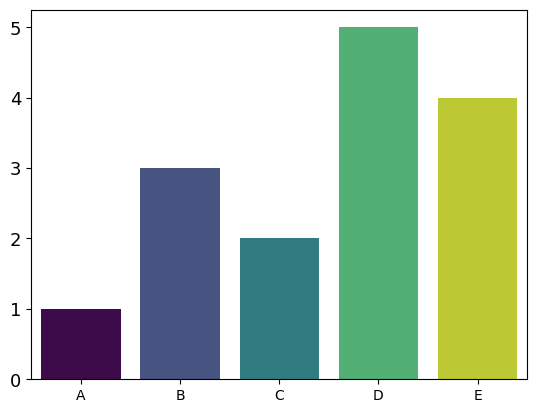

In [32]:
# first plot a bar chart for F1 MCC for all models
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import to_hex
import pandas as pd
from sklearn.metrics import f1_score, matthews_corrcoef, confusion_matrix
plt.rcParams.update({
    "font.size": 12,  
    # Base font size
    "axes.titlesize": 16,      # Axis title font size
    "axes.labelsize": 15,      # Axis label font size
    "xtick.labelsize": 10,     # X-axis tick label font size
    "ytick.labelsize": 13      # Y-axis tick label font size
})
n_colors = 5
viridis = plt.cm.viridis
colors = [to_hex(viridis(i)) for i in np.linspace(0, 0.93, n_colors)]

# Apply the palette
custom_palette = sns.color_palette(colors)

# Example plot
sns.set_palette(custom_palette)
sns.barplot(x=["A", "B", "C", "D", "E"], y=[1, 3, 2, 5, 4])
plt.show()

In [33]:
def random_baseline(y_true):
    return np.random.choice([0, 1], len(y_true))

In [34]:
models = ['Pakhrin et al. 2023', 'Ours (oversampled)', 'Ours (no oversampling)', 'Ours (3class)', 'VespaG Basline']
# calculate F1 MCC for all models
def calc_f1_mcc(y_true, y_pred):
    f1s, mccs = calculate_metrics_bootstrap(y_true, y_pred)
    _, f1_ci = mean_confidence_interval(f1s)
    _, mcc_ci = mean_confidence_interval(mccs)
    f1 = f1_score(y_true, y_pred, average="macro")
    mcc = matthews_corrcoef(y_true, y_pred)
    return f1, f1_ci, mcc, mcc_ci
their_f1, their_f1_ci, their_mcc, their_mcc_ci = calc_f1_mcc(y_independent_theirs, y_pred_theirs)
ours_oversamp_f1, ours_oversamp_f1_ci, ours_oversamp_mcc, ours_oversamp_mcc_ci = calc_f1_mcc(y_independent_ours_oversamp, y_pred_ours_oversamp)
ours_nooversamp_f1, ours_nooversamp_f1_ci, ours_nooversamp_mcc, ours_nooversamp_mcc_ci = calc_f1_mcc(y_independent_ours_nooversamp, y_pred_ours_nooversamp)
ours_3class_f1, ours_3class_f1_ci, ours_3class_mcc, ours_3class_mcc_ci = calc_f1_mcc(y_independent_ours_3class, y_pred_ours_3class)
vespag_f1, vespag_f1_ci, vespag_mcc, vespag_mcc_ci = calc_f1_mcc(y_independent_vespaG, y_pred_vespaG)
random_f1, random_f1_ci, random_mcc, random_mcc_ci = calc_f1_mcc(y_independent, random_baseline(y_independent))

In [35]:
print(f"Their model: F1 {their_f1:.3f} ({their_f1_ci:.3f}), MCC {their_mcc:.3f} ({their_mcc_ci:.3f})")
print(f"Our model (oversampled): F1 {ours_oversamp_f1:.3f} ({ours_oversamp_f1_ci:.3f}), MCC {ours_oversamp_mcc:.3f} ({ours_oversamp_mcc_ci:.3f})")
print(f"Our model (no oversampling): F1 {ours_nooversamp_f1:.3f} ({ours_nooversamp_f1_ci:.3f}), MCC {ours_nooversamp_mcc:.3f} ({ours_nooversamp_mcc_ci:.3f})")
print(f"Our model (3class): F1 {ours_3class_f1:.3f} ({ours_3class_f1_ci:.3f}), MCC {ours_3class_mcc:.3f} ({ours_3class_mcc_ci:.3f})")
print(f"VespaG Baseline: F1 {vespag_f1:.3f} ({vespag_f1_ci:.3f}), MCC {vespag_mcc:.3f} ({vespag_mcc_ci:.3f})")
print(f"Random Baseline: F1 {random_f1:.3f} ({random_f1_ci:.3f}), MCC {random_mcc:.3f} ({random_mcc_ci:.3f})")


Their model: F1 0.744 (0.001), MCC 0.498 (0.001)
Our model (oversampled): F1 0.720 (0.001), MCC 0.450 (0.001)
Our model (no oversampling): F1 0.715 (0.001), MCC 0.446 (0.001)
Our model (3class): F1 0.679 (0.001), MCC 0.448 (0.001)
VespaG Baseline: F1 0.599 (0.001), MCC 0.204 (0.001)
Random Baseline: F1 0.496 (0.001), MCC 0.013 (0.001)


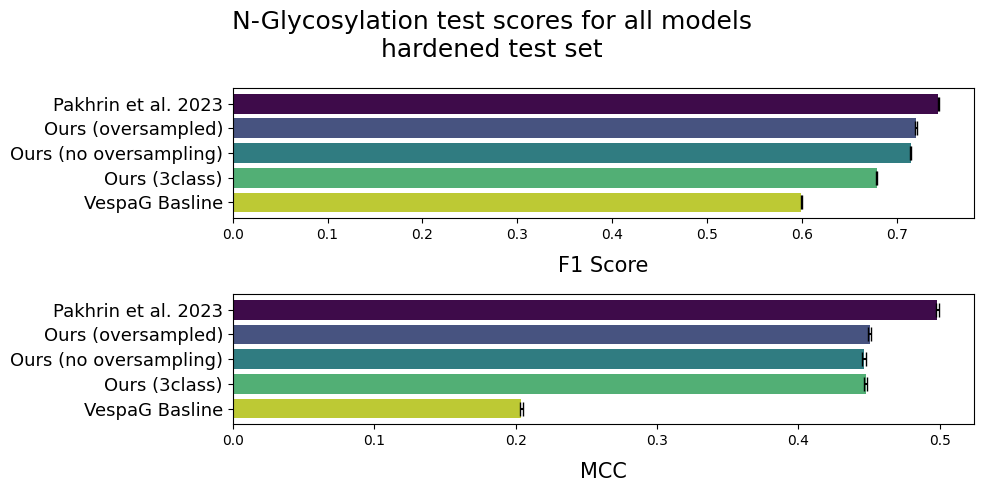

In [36]:


f1s = [their_f1, ours_oversamp_f1, ours_nooversamp_f1, ours_3class_f1, vespag_f1]
mccs = [their_mcc, ours_oversamp_mcc, ours_nooversamp_mcc, ours_3class_mcc, vespag_mcc]
df = pd.DataFrame({'Model': models, 'F1': f1s, 'MCC': mccs})
# y axis should be the metrics comparing all models against each other
# bars should be horizontal
fig, ax = plt.subplots(2, 1, figsize=(10, 5))
fig.suptitle('N-Glycosylation test scores for all models\nhardened test set', fontsize=18)
sns.barplot(x='F1', y='Model', data=df, ax=ax[0])
ax[0].errorbar(f1s, 
               models, 
               xerr=[their_f1_ci, ours_oversamp_f1_ci, ours_nooversamp_f1_ci, ours_3class_f1_ci, vespag_f1_ci], 
               fmt='none', 
               color='black', 
               capsize=5)
#space between the two plots
plt.subplots_adjust(hspace=0.5)
sns.barplot(x='MCC', y='Model', data=df, ax=ax[1])
ax[1].errorbar(mccs, 
               models, 
               xerr=[their_mcc_ci, ours_oversamp_mcc_ci, ours_nooversamp_mcc_ci, ours_3class_mcc_ci, vespag_mcc_ci], 
               fmt='none', 
               color='black', 
               capsize=5)

ax[0].set_ylabel('')
ax[1].set_ylabel('')
ax[0].set_xlabel('F1 Score', labelpad=10)
ax[1].set_xlabel('MCC', labelpad=10)
plt.tight_layout()
plt.savefig('results/plots/N_glyco_f1_mcc.png', dpi=300, bbox_inches = "tight")
plt.show()



In [37]:
models = ['Pakhrin et al. 2023', 'Ours (oversampled)', 'Ours (no oversampling)', 'Ours (3class)', 'VespaG Basline']
# calculate F1 MCC for all models

their_f1, their_f1_ci, their_mcc, their_mcc_ci = calc_f1_mcc(y_independent_theirs_u, y_pred_theirs_u)
ours_oversamp_f1, ours_oversamp_f1_ci, ours_oversamp_mcc, ours_oversamp_mcc_ci = calc_f1_mcc(y_independent_ours_oversamp_u, y_pred_ours_oversamp_u)
ours_nooversamp_f1, ours_nooversamp_f1_ci, ours_nooversamp_mcc, ours_nooversamp_mcc_ci = calc_f1_mcc(y_independent_ours_nooversamp_u, y_pred_ours_nooversamp_u)
ours_3class_f1, ours_3class_f1_ci, ours_3class_mcc, ours_3class_mcc_ci = calc_f1_mcc(y_independent_ours_3class_u, y_pred_ours_3class_u)
vespag_f1, vespag_f1_ci, vespag_mcc, vespag_mcc_ci = calc_f1_mcc(y_independent_vespaG_u, y_pred_vespaG_u)
random_f1, random_f1_ci, random_mcc, random_mcc_ci = calc_f1_mcc(y_independent_u, random_baseline(y_independent_u))

In [38]:
print(f"Their model: F1 {their_f1:.3f} ({their_f1_ci:.3f}), MCC {their_mcc:.3f} ({their_mcc_ci:.3f})")
print(f"Our model (oversampled): F1 {ours_oversamp_f1:.3f} ({ours_oversamp_f1_ci:.3f}), MCC {ours_oversamp_mcc:.3f} ({ours_oversamp_mcc_ci:.3f})")
print(f"Our model (no oversampling): F1 {ours_nooversamp_f1:.3f} ({ours_nooversamp_f1_ci:.3f}), MCC {ours_nooversamp_mcc:.3f} ({ours_nooversamp_mcc_ci:.3f})")
print(f"Our model (3class): F1 {ours_3class_f1:.3f} ({ours_3class_f1_ci:.3f}), MCC {ours_3class_mcc:.3f} ({ours_3class_mcc_ci:.3f})")
print(f"VespaG Baseline: F1 {vespag_f1:.3f} ({vespag_f1_ci:.3f}), MCC {vespag_mcc:.3f} ({vespag_mcc_ci:.3f})")
print(f"Random Baseline: F1 {random_f1:.3f} ({random_f1_ci:.3f}), MCC {random_mcc:.3f} ({random_mcc_ci:.3f})")

Their model: F1 0.756 (0.001), MCC 0.512 (0.001)
Our model (oversampled): F1 0.729 (0.001), MCC 0.459 (0.001)
Our model (no oversampling): F1 0.735 (0.001), MCC 0.470 (0.001)
Our model (3class): F1 0.727 (0.001), MCC 0.494 (0.001)
VespaG Baseline: F1 0.586 (0.001), MCC 0.220 (0.001)
Random Baseline: F1 0.491 (0.001), MCC -0.017 (0.002)


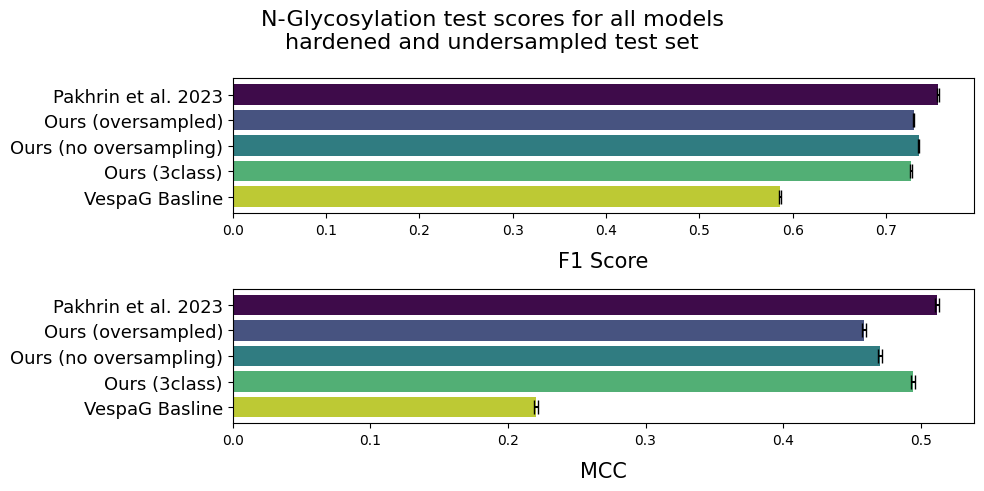

In [39]:


f1s = [their_f1, ours_oversamp_f1, ours_nooversamp_f1, ours_3class_f1, vespag_f1]
mccs = [their_mcc, ours_oversamp_mcc, ours_nooversamp_mcc, ours_3class_mcc, vespag_mcc]
df = pd.DataFrame({'Model': models, 'F1': f1s, 'MCC': mccs})
# y axis should be the metrics comparing all models against each other
# bars should be horizontal
fig, ax = plt.subplots(2, 1, figsize=(10, 5))
#increase overall fontsize



fig.suptitle('N-Glycosylation test scores for all models\nhardened and undersampled test set', fontsize=16)
sns.barplot(x='F1', y='Model', data=df, ax=ax[0])
ax[0].errorbar(f1s, 
               models, 
               xerr=[their_f1_ci, ours_oversamp_f1_ci, ours_nooversamp_f1_ci, ours_3class_f1_ci, vespag_f1_ci], 
               fmt='none', 
               color='black', 
               capsize=5)
#space between the two plots
plt.subplots_adjust(hspace=0.5)
sns.barplot(x='MCC', y='Model', data=df, ax=ax[1])

ax[1].errorbar(mccs, 
               models, 
               xerr=[their_mcc_ci, ours_oversamp_mcc_ci, ours_nooversamp_mcc_ci, ours_3class_mcc_ci, vespag_mcc_ci], 
               fmt='none', 
               color='black', 
               capsize=5)
ax[0].set_ylabel('')
ax[1].set_ylabel('')
ax[0].set_xlabel('F1 Score', labelpad=10)
ax[1].set_xlabel('MCC', labelpad=10)
plt.tight_layout()
plt.savefig('results/plots/N_glyco_f1_mcc_undersampled.png', dpi=300, bbox_inches = "tight")
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

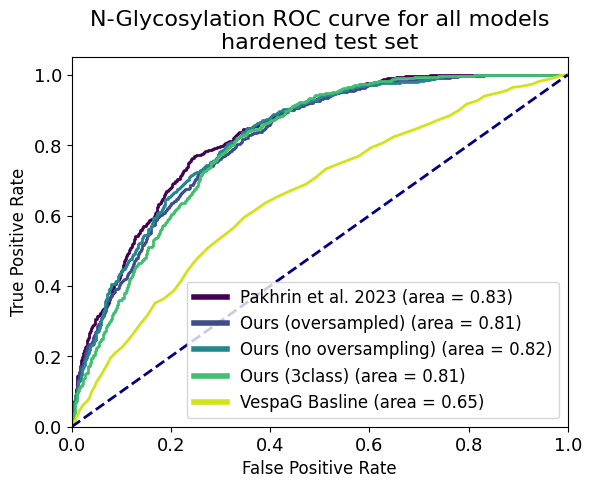

In [40]:

plt.rcParams.update({
    "font.size": 12,           # Base font size
    "axes.titlesize": 16,      # Axis title font size
    "axes.labelsize": 15,      # Axis label font size
    "xtick.labelsize": 13,     # X-axis tick label font size
    "ytick.labelsize": 13      # Y-axis tick label font size
})
fpr_theirs, tpr_theirs, _ = roc_curve(y_independent_theirs, Y_pred_theirs[:,1])
roc_auc_theirs = auc(fpr_theirs, tpr_theirs)
fpr_ours_oversamp, tpr_ours_oversamp, _ = roc_curve(y_independent_ours_oversamp, Y_pred_ours_oversampled)
roc_auc_ours_oversamp = auc(fpr_ours_oversamp, tpr_ours_oversamp)
fpr_ours_nooversamp, tpr_ours_nooversamp, _ = roc_curve(y_independent_ours_nooversamp, Y_pred_ours_nooversampling)
roc_auc_ours_nooversamp = auc(fpr_ours_nooversamp, tpr_ours_nooversamp)
fpr_ours_3class, tpr_ours_3class, _ = roc_curve(y_independent_ours_3class, Y_pred_ours_3class[:,1])
roc_auc_ours_3class = auc(fpr_ours_3class, tpr_ours_3class)
fpr_vespag, tpr_vespag, _ = roc_curve(y_independent_vespaG, Y_pred_vespaG[:,1])
roc_auc_vespag = auc(fpr_vespag, tpr_vespag)
plt.figure()
lw = 2
# use the same colors as the bar plot from the seaborn palette
plt.plot(fpr_theirs, tpr_theirs, color=colors[0],
         lw=lw, label='Pakhrin et al. 2023 (area = %0.2f)' % roc_auc_theirs)
plt.plot(fpr_ours_oversamp, tpr_ours_oversamp, color=colors[1],
            lw=lw, label='Ours (oversampled) (area = %0.2f)' % roc_auc_ours_oversamp)
plt.plot(fpr_ours_nooversamp, tpr_ours_nooversamp, color=colors[2],
            lw=lw, label='Ours (no oversampling) (area = %0.2f)' % roc_auc_ours_nooversamp)
plt.plot(fpr_ours_3class, tpr_ours_3class, color=colors[3],
            lw=lw, label='Ours (3class) (area = %0.2f)' % roc_auc_ours_3class)
plt.plot(fpr_vespag, tpr_vespag, color=colors[4],
            lw=lw, label='VespaG Basline (area = %0.2f)' % roc_auc_vespag)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('N-Glycosylation ROC curve for all models\nhardened test set')
legend = plt.legend(markerfirst=True, loc="lower right", fontsize=12, )
for line in legend.get_lines():
    line.set_linewidth(4) 
plt.savefig('results/plots/N_glyco_roc.png', dpi=300, bbox_inches = "tight")
plt.show


<function matplotlib.pyplot.show(close=None, block=None)>

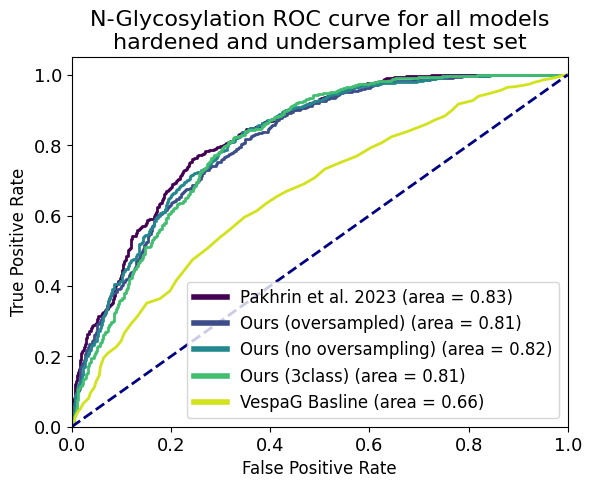

In [41]:
fpr_theirs, tpr_theirs, _ = roc_curve(y_independent_theirs_u, Y_pred_theirs_u[:,1])
roc_auc_theirs = auc(fpr_theirs, tpr_theirs)
fpr_ours_oversamp, tpr_ours_oversamp, _ = roc_curve(y_independent_ours_oversamp_u, Y_pred_ours_oversampled_u)
roc_auc_ours_oversamp = auc(fpr_ours_oversamp, tpr_ours_oversamp)
fpr_ours_nooversamp, tpr_ours_nooversamp, _ = roc_curve(y_independent_ours_nooversamp_u, Y_pred_ours_nooversampling_u)
roc_auc_ours_nooversamp = auc(fpr_ours_nooversamp, tpr_ours_nooversamp)
fpr_ours_3class, tpr_ours_3class, _ = roc_curve(y_independent_ours_3class_u, Y_pred_ours_3class_u[:,1])
roc_auc_ours_3class = auc(fpr_ours_3class, tpr_ours_3class)
fpr_vespag, tpr_vespag, _ = roc_curve(y_independent_vespaG_u, Y_pred_vespaG_u[:,1])
roc_auc_vespag = auc(fpr_vespag, tpr_vespag)
plt.figure()
lw = 2
# use the same colors as the bar plot from the seaborn palette
plt.plot(fpr_theirs, tpr_theirs, color=colors[0],
         lw=lw, label='Pakhrin et al. 2023 (area = %0.2f)' % roc_auc_theirs)
plt.plot(fpr_ours_oversamp, tpr_ours_oversamp, color=colors[1],
            lw=lw, label='Ours (oversampled) (area = %0.2f)' % roc_auc_ours_oversamp)
plt.plot(fpr_ours_nooversamp, tpr_ours_nooversamp, color=colors[2],
            lw=lw, label='Ours (no oversampling) (area = %0.2f)' % roc_auc_ours_nooversamp)
plt.plot(fpr_ours_3class, tpr_ours_3class, color=colors[3],
            lw=lw, label='Ours (3class) (area = %0.2f)' % roc_auc_ours_3class)
plt.plot(fpr_vespag, tpr_vespag, color=colors[4],
            lw=lw, label='VespaG Basline (area = %0.2f)' % roc_auc_vespag)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('N-Glycosylation ROC curve for all models\nhardened and undersampled test set')
legend = plt.legend(markerfirst=True, loc="lower right", fontsize=12, )
for line in legend.get_lines():
    line.set_linewidth(4) 
plt.savefig('results/plots/N_glyco_roc_undersampled.png', dpi=300, bbox_inches = "tight")
plt.show


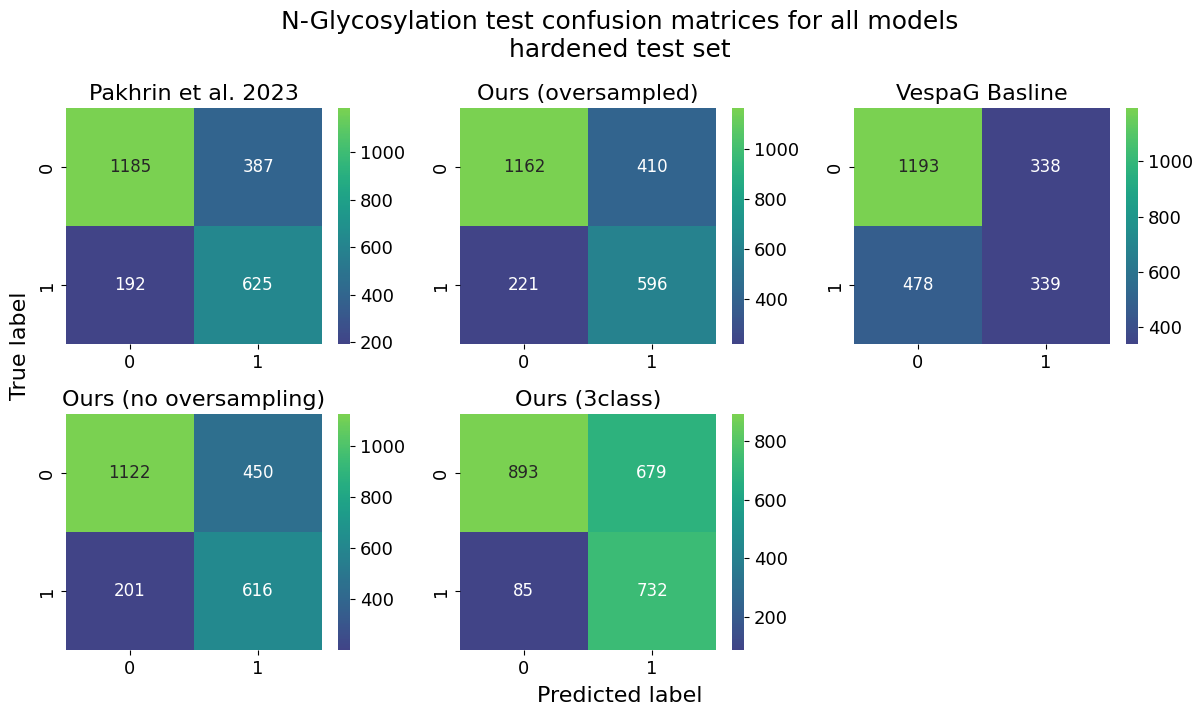

In [42]:
# confusion matrix for all models
from sklearn.metrics import confusion_matrix
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Customize the Viridis colormap (e.g., use only the first half of the colors)
custom_cmap = LinearSegmentedColormap.from_list("custom_viridis", viridis(np.linspace(0.2, 0.8, 256)))

fig, ax = plt.subplots(2, 3, figsize=(12, 7))
fig.suptitle('N-Glycosylation test confusion matrices for all models\nhardened test set', fontsize=18)

sns.heatmap(confusion_matrix(y_independent_theirs, y_pred_theirs), annot=True, fmt='d', ax=ax[0, 0], cmap=custom_cmap)
ax[0, 0].set_title('Pakhrin et al. 2023')
sns.heatmap(confusion_matrix(y_independent_ours_oversamp, y_pred_ours_oversamp), annot=True, fmt='d', ax=ax[0, 1], cmap=custom_cmap)
ax[0, 1].set_title('Ours (oversampled)')
sns.heatmap(confusion_matrix(y_independent_ours_nooversamp, y_pred_ours_nooversamp), annot=True, fmt='d', ax=ax[1, 0], cmap=custom_cmap)
ax[1, 0].set_title('Ours (no oversampling)')
sns.heatmap(confusion_matrix(y_independent_ours_3class, y_pred_ours_3class), annot=True, fmt='d', ax=ax[1, 1], cmap=custom_cmap)
ax[1, 1].set_title('Ours (3class)')
sns.heatmap(confusion_matrix(y_independent_vespaG, y_pred_vespaG), annot=True, fmt='d', ax=ax[0, 2], cmap=custom_cmap)
ax[0, 2].set_title('VespaG Basline')
fig.delaxes(ax[1,2])

plt.subplots_adjust(hspace=0.3, wspace=0.3)  # Increase the value to increase the space
plt.tight_layout()
fig.text(0.5, 0.00, 'Predicted label', ha='center', va='center', fontsize=16)
fig.text(0.00, 0.5, 'True label', ha='center', va='center', rotation='vertical', fontsize=16)
plt.savefig('results/plots/N_glyco_confusion_matrices.png', dpi=300, bbox_inches = "tight")
plt.show()

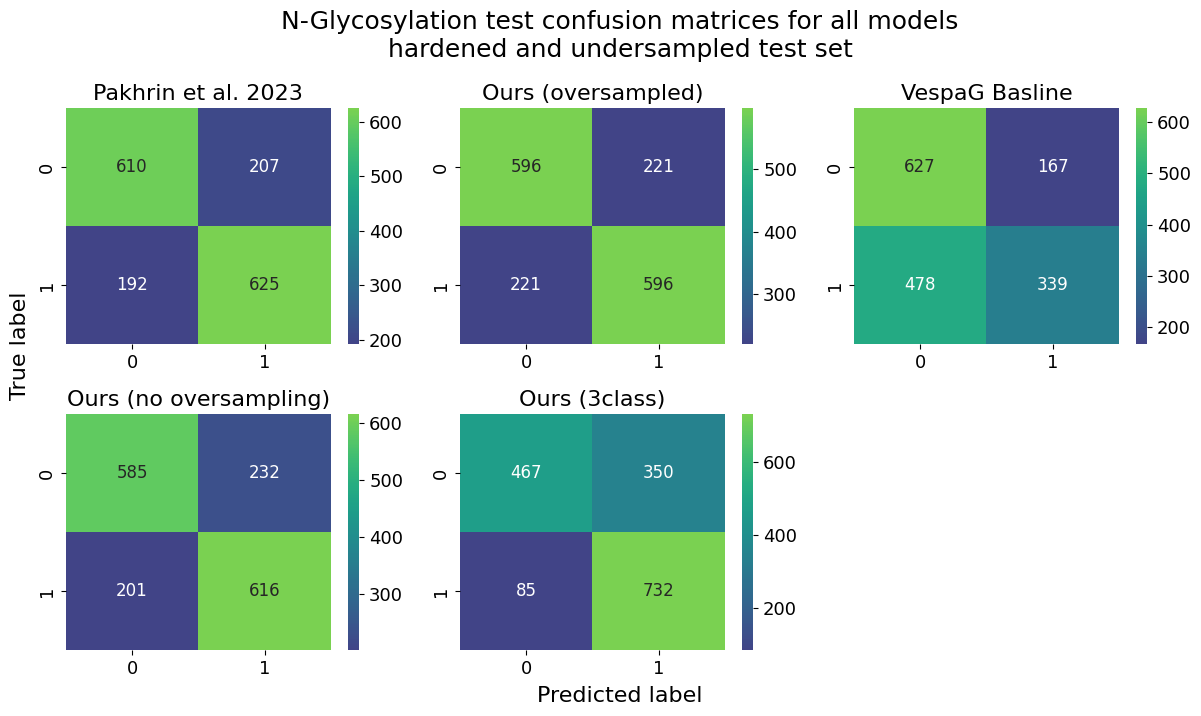

In [43]:
# confusion matrix for all models
from sklearn.metrics import confusion_matrix
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Customize the Viridis colormap (e.g., use only the first half of the colors)
custom_cmap = LinearSegmentedColormap.from_list("custom_viridis", viridis(np.linspace(0.2, 0.8, 256)))

fig, ax = plt.subplots(2, 3, figsize=(12, 7))
fig.suptitle('N-Glycosylation test confusion matrices for all models\nhardened and undersampled test set', fontsize=18)

sns.heatmap(confusion_matrix(y_independent_theirs_u, y_pred_theirs_u), annot=True, fmt='d', ax=ax[0, 0], cmap=custom_cmap)
ax[0, 0].set_title('Pakhrin et al. 2023')
sns.heatmap(confusion_matrix(y_independent_ours_oversamp_u, y_pred_ours_oversamp_u), annot=True, fmt='d', ax=ax[0, 1], cmap=custom_cmap)
ax[0, 1].set_title('Ours (oversampled)')
sns.heatmap(confusion_matrix(y_independent_ours_nooversamp_u, y_pred_ours_nooversamp_u), annot=True, fmt='d', ax=ax[1, 0], cmap=custom_cmap)
ax[1, 0].set_title('Ours (no oversampling)')
sns.heatmap(confusion_matrix(y_independent_ours_3class_u, y_pred_ours_3class_u), annot=True, fmt='d', ax=ax[1, 1], cmap=custom_cmap)
ax[1, 1].set_title('Ours (3class)')
sns.heatmap(confusion_matrix(y_independent_vespaG_u, y_pred_vespaG_u), annot=True, fmt='d', ax=ax[0, 2], cmap=custom_cmap)
ax[0, 2].set_title('VespaG Basline')
fig.delaxes(ax[1,2])
plt.subplots_adjust(hspace=0.3, wspace=0.3)  # Increase the value to increase the space
plt.tight_layout()
fig.text(0.5, 0.00, 'Predicted label', ha='center', va='center', fontsize=16)
fig.text(0.00, 0.5, 'True label', ha='center', va='center', rotation='vertical', fontsize=16)
plt.savefig('results/plots/N_glyco_confusion_matrices_undersampled.png', dpi=300, bbox_inches = "tight")
plt.show()

# There is no redundant protein in training set and independent test set

In [44]:
import numpy as np

df = pd.read_csv("df_train_data_without_indepenent_test_and_protein.csv")

print(df["label"].value_counts())

FileNotFoundError: [Errno 2] No such file or directory: 'df_train_data_without_indepenent_test_and_protein.csv'

In [ ]:
Training_Protein_ID = set(df["PID"])

In [ ]:
df_test = pd.read_csv("df_indepenent_test_again_done_that_has_unique_protein_and_unique_sequence.csv")
Independent_Test_Set_Protein_ID = set(df_test["PID"])

In [ ]:
Training_Protein_ID.intersection(Independent_Test_Set_Protein_ID)

set()

# There is no redundant protein in training set and independent test set

In [ ]:
Training_Protein_Sequence = set(df["Sequence"])

In [ ]:
Independent_Test_Set_Sequence = set(df_test["Sequence"])

In [ ]:
Training_Protein_Sequence.intersection(Independent_Test_Set_Sequence)

set()

# Thank You